In [1]:
!splitcode --version
!fasterq-dump --version

splitcode, version 0.30.0

fasterq-dump : 3.0.3 ( 3.0.2 )



In [2]:
import multiprocessing

# Directories where fasta and alignment data will be stored
outdir = "/mnt/data1/10XvParse/Analysis_4/"
raw_folder = "FASTA/Raw/"
wells_folder = "FASTA/wells/"
tmp_folder = "tmp/"
proc_folder = "FASTA/Processed/"


In [3]:
import os

def make_dir(directory_name, outdir = ""):
    path = outdir+directory_name
    try:
        os.makedirs(path)
        print(f"Directory '{directory_name}' created successfully.")
    except FileExistsError:
        print(f"Directory '{directory_name}' already exists.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [4]:
# Ensure necessary sub-directories exist
for directory_name in [raw_folder, proc_folder, 
                       tmp_folder, wells_folder]:
    make_dir(directory_name, outdir)

Directory 'FASTA/Raw/' already exists.
Directory 'FASTA/Processed/' already exists.
Directory 'tmp/' already exists.
Directory 'FASTA/wells/' already exists.


In [5]:
make_dir("batch")
make_dir("run_info")

Directory 'batch' already exists.
Directory 'run_info' already exists.


In [6]:
file_names = []
for i in range(1, 16):
    for j in range(1, 5):
        file_names.append(f"Sublibrary_{i+1}_S{i}_L00{j}")

In [7]:
# Generate batch file to combine all fasta files into one file
batch_file = f"batch/parse_batch.txt"
with open(batch_file, "w") as batch:
    dir = "nova1/"
    for file in file_names:
        fastq_files = [outdir + raw_folder + dir + file + "_R1_001.fastq.gz", 
                outdir + raw_folder + dir + file + "_R2_001.fastq.gz"]
        batch.write(f"{file}\t{fastq_files[0]}\t{fastq_files[1]}\n")

In [ ]:
# Combine fasta files into one large parse file
mapping = f"run_info/parse_mapping.txt"
outb = f"run_info/parse_barcodes.fastq.gz"
proc_files = [outdir + proc_folder + f"parse_1.fasta.gz",
                outdir + proc_folder + f"parse_2.fasta.gz"]
!splitcode --remultiplex -c parse_extraction/config_correct.txt\
    --nFastqs=2 --gzip -o {proc_files[0]},{proc_files[1]} \
    --out-fasta --outb={outb} --mapping={mapping} {batch_file} -t 8

* Using a list of 64 tags (vector size: 64; map size: 2,112; num elements in map: 2,112)
* will process sample 1: /mnt/data1/10XvParse/Analysis_4/FASTA/Raw/nova1/Sublibrary_2_S1_L001_R1_001.fastq.gz
                         /mnt/data1/10XvParse/Analysis_4/FASTA/Raw/nova1/Sublibrary_2_S1_L001_R2_001.fastq.gz
* will process sample 2: /mnt/data1/10XvParse/Analysis_4/FASTA/Raw/nova1/Sublibrary_2_S1_L002_R1_001.fastq.gz
                         /mnt/data1/10XvParse/Analysis_4/FASTA/Raw/nova1/Sublibrary_2_S1_L002_R2_001.fastq.gz
* will process sample 3: /mnt/data1/10XvParse/Analysis_4/FASTA/Raw/nova1/Sublibrary_2_S1_L003_R1_001.fastq.gz
                         /mnt/data1/10XvParse/Analysis_4/FASTA/Raw/nova1/Sublibrary_2_S1_L003_R2_001.fastq.gz
* will process sample 4: /mnt/data1/10XvParse/Analysis_4/FASTA/Raw/nova1/Sublibrary_2_S1_L004_R1_001.fastq.gz
                         /mnt/data1/10XvParse/Analysis_4/FASTA/Raw/nova1/Sublibrary_2_S1_L004_R2_001.fastq.gz
* will process sample 5: /mnt/d

In [9]:
# Generate config file to separate reads by well
distances = 1
locations = "1:78:86"
with open("parse_extraction/config_RT.txt", "w") as config:
    config.write("tags\tsubs\tdistances\tlocations\n")
    with open("parse_extraction/r1_R.txt") as randO:
        with open("parse_extraction/r1_T.txt") as polyT:
            for lineO, lineT in zip(randO,polyT):
                lineO = lineO.strip()
                lineT = lineT.strip()
                config.write(f"{lineO}\t{lineT}\t{distances}\t{locations}\n")

In [10]:
# Divide the reads into different wells

with open("parse_extraction/keep_wells.txt", "w") as keep, open("parse_extraction/config_wells.txt", "w") as config:
    n = 0
    with open("parse_extraction/r1_R.txt", "r") as R:
        keep.truncate()
        config.truncate()
        config.write("tags\tlocations\tdistances\n")

        for line in R:
            n += 1
            keep.write(line.strip() + "\t" + outdir + f"{wells_folder}randO_well_" + str(n) + "\n")
            config.write(line.strip() + "\t" + "1:78:86" + "\t\t" + "1" + "\n")

    n = 0
    with open("parse_extraction/r1_T.txt", "r") as T:
        for line in T:
            n += 1
            keep.write(line.strip() + "\t" + outdir +  f"{wells_folder}polyT_well_" + str(n) + "\n")
            config.write(line.strip() + "\t" + "1:78:86" + "\t\t" + "1" + "\n")

In [ ]:
proc_files = [outdir + proc_folder + f"parse_1.fasta.gz",
                outdir + proc_folder + f"parse_2.fasta.gz"]
# Extract by well
!splitcode -c parse_extraction/config_wells.txt --gzip --keep-r1-r2 \
    --keep=parse_extraction/keep_wells.txt --nFastqs=2 --no-output \
    --out-fasta --no-outb {proc_files[0]} {proc_files[1]} -t 8

* Using a list of 192 tags (vector size: 192; map size: 5,885; num elements in map: 6,336)
* will process sample 1: /mnt/data1/10XvParse/Analysis_4/FASTA/Processed/parse_1.fasta.gz
                         /mnt/data1/10XvParse/Analysis_4/FASTA/Processed/parse_2.fasta.gz
615M reads processed         

In [8]:
# Extract polyT reads
polyT_files = [outdir+proc_folder+f"polyT_1.fasta.gz",
                outdir+proc_folder+f"polyT_2.fasta.gz"]
proc_files = [outdir + proc_folder + f"parse_1.fasta.gz",
                outdir + proc_folder + f"parse_2.fasta.gz"]

!splitcode -c parse_extraction/config_RT_polyT.txt --nFastqs=2 --gzip \
    --assign --out-fasta -o {polyT_files[0]},{polyT_files[1]} \
    --outb=run_info/polyT_barcodes.fastq.gz --mapping=run_info/polyT_mapping.txt\
    --summary=run_info/polyT_summary.txt \
    {proc_files[0]} {proc_files[1]} -t 8

* Using a list of 96 tags (vector size: 96; map size: 3,027; num elements in map: 3,168)
* will process sample 1: /mnt/data1/10XvParse/Analysis_4/FASTA/Processed/parse_1.fasta.gz
                         /mnt/data1/10XvParse/Analysis_4/FASTA/Processed/parse_2.fasta.gz
2839M reads processed (47.8% assigned)
done 
* processed 2,843,676,124 reads, 1,359,436,771 reads were assigned


In [9]:
# Extract randO reads
randO_files = [outdir+proc_folder+f"randO_1.fasta.gz",
                outdir+proc_folder+f"randO_2.fasta.gz"]
proc_files = [outdir + proc_folder + f"parse_1.fasta.gz",
                outdir + proc_folder + f"parse_2.fasta.gz"]

!splitcode -c parse_extraction/config_RT_randO.txt --nFastqs=2 --gzip \
    --assign -o {randO_files[0]},{randO_files[1]} --outb=run_info/randO_barcodes.fastq.gz \
    --mapping=run_info/randO_mapping.txt --summary=run_info/randO_summary.txt \
    --out-fasta {proc_files[0]} {proc_files[1]} -t 8

* Using a list of 96 tags (vector size: 96; map size: 2,989; num elements in map: 3,168)
* will process sample 1: /mnt/data1/10XvParse/Analysis_4/FASTA/Processed/parse_1.fasta.gz
                         /mnt/data1/10XvParse/Analysis_4/FASTA/Processed/parse_2.fasta.gz
2839M reads processed (30.5% assigned)
done 
* processed 2,843,676,124 reads, 868,177,571 reads were assigned


In [10]:
# Download mouse genome. This experiment used C57BL/6N (Black 6) mice, so we can use a general reference genome. 
!kb ref --overwrite -d mouse -i index.idx -g t2g.txt

[2025-09-08 14:53:04,146]    INFO [download] Downloading files for mouse (standard workflow) from https://github.com/pachterlab/kallisto-transcriptome-indices/releases/download/v1/mouse_index_standard.tar.xz to tmp/mouse_index_standard.tar.xz
100%|██████████████████████████████████████| 82.8M/82.8M [00:02<00:00, 31.9MB/s]
[2025-09-08 14:53:06,870]    INFO [download] Extracting files from tmp/mouse_index_standard.tar.xz


In [11]:
# Prepare batch file to pseudalign reads by well
rando_well = outdir + "FASTA/wells/randO_well_"
polyt_well = outdir + "FASTA/wells/polyT_well_"
with open("parse_extraction/batch_wells.txt", "w") as batch:
    batch.truncate()
    for n in range(1,97):
        batch.write("RandO_Well" + str(n) + "\t" + rando_well + str(n) + "_R1.fasta.gz\t" + rando_well + str(n) + "_R2.fasta.gz\n")
    for n in range(1,97):
        batch.write("PolyT_Well" + str(n) + "\t" + polyt_well + str(n) + "_R1.fasta.gz\t" + polyt_well + str(n) + "_R2.fasta.gz\n")

In [14]:
# Pseudoalign all parse reads
parse_out = outdir + f"parse_out"
proc_files = [outdir + proc_folder + f"parse_1.fasta.gz",
              outdir + proc_folder + f"parse_2.fasta.gz"]
!kb count --overwrite --h5ad -r parse_extraction/replace.txt -i index.idx -g t2g.txt -x SPLIT-SEQ -o {parse_out} {proc_files[0]} {proc_files[1]}

[2025-09-08 14:55:24,122]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_4/parse_out from
[2025-09-08 14:55:24,122]    INFO [count]         /mnt/data1/10XvParse/Analysis_4/FASTA/Processed/parse_1.fasta.gz
[2025-09-08 14:55:24,122]    INFO [count]         /mnt/data1/10XvParse/Analysis_4/FASTA/Processed/parse_2.fasta.gz
[2025-09-08 19:22:05,412]    INFO [count] Sorting BUS file /mnt/data1/10XvParse/Analysis_4/parse_out/output.bus to /mnt/data1/10XvParse/Analysis_4/parse_out/tmp/output.s.bus
[2025-09-08 19:25:17,801]    INFO [count] On-list not provided
[2025-09-08 19:25:17,801]    INFO [count] Copying pre-packaged SPLIT-SEQ on-list to /mnt/data1/10XvParse/Analysis_4/parse_out
[2025-09-08 19:25:17,802]    INFO [count] Inspecting BUS file /mnt/data1/10XvParse/Analysis_4/parse_out/tmp/output.s.bus
[2025-09-08 19:25:52,858]    INFO [count] Correcting BUS records in /mnt/data1/10XvParse/Analysis_4/parse_out/tmp/output.s.bus to /mnt/data1/10XvParse/

In [ ]:
wells_out = outdir + "wells_out"
# Pseudoalign parse reads by well
!kb count --overwrite --h5ad -i index.idx -g t2g.txt -x SPLIT-SEQ -o {wells_out} --batch-barcodes parse_extraction/batch_wells.txt

[2025-09-08 19:38:08,697]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_4/wells_out from
[2025-09-08 19:38:08,697]    INFO [count]         /mnt/data1/10XvParse/Analysis_4/wells_out/tmp/tmp1fp_h2vl


In [ ]:
# Perform pseudoalignment of polyT reads
polyT_out = outdir + f"polyT_out"
polyT_files = [outdir + proc_folder + f"polyT_1.fasta.gz",
                outdir + proc_folder + f"polyT_2.fasta.gz"]
!kb count --overwrite --h5ad -i index.idx -g t2g.txt -x SPLIT-SEQ -o {polyT_out} {polyT_files[0]} {polyT_files[1]} 

[2025-08-28 16:27:49,584]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_2/polyT_out from
[2025-08-28 16:27:49,584]    INFO [count]         /mnt/data1/10XvParse/Analysis_2/FASTA/Processed/polyT_1.fasta.gz
[2025-08-28 16:27:49,584]    INFO [count]         /mnt/data1/10XvParse/Analysis_2/FASTA/Processed/polyT_2.fasta.gz
[2025-08-28 16:45:58,235]    INFO [count] Sorting BUS file /mnt/data1/10XvParse/Analysis_2/polyT_out/output.bus to /mnt/data1/10XvParse/Analysis_2/polyT_out/tmp/output.s.bus
[2025-08-28 16:46:06,344]    INFO [count] On-list not provided
[2025-08-28 16:46:06,344]    INFO [count] Copying pre-packaged SPLIT-SEQ on-list to /mnt/data1/10XvParse/Analysis_2/polyT_out
[2025-08-28 16:46:06,344]    INFO [count] Inspecting BUS file /mnt/data1/10XvParse/Analysis_2/polyT_out/tmp/output.s.bus
[2025-08-28 16:46:09,348]    INFO [count] Correcting BUS records in /mnt/data1/10XvParse/Analysis_2/polyT_out/tmp/output.s.bus to /mnt/data1/10XvParse/

In [ ]:
# Perform pseudoalignment of randO reads 
randO_out = outdir + f"randO_out"
randO_files = [outdir + proc_folder + f"randO_1.fasta.gz",
                outdir + proc_folder + f"randO_2.fasta.gz"]
!kb count --overwrite --h5ad -r parse_extraction/replace.txt -i index.idx -g t2g.txt -x SPLIT-SEQ -o {randO_out} {randO_files[0]} {randO_files[1]}

[2025-09-09 09:50:14,605]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_4/randO_out from
[2025-09-09 09:50:14,605]    INFO [count]         /mnt/data1/10XvParse/Analysis_4/FASTA/Processed/randO_1.fasta.gz
[2025-09-09 09:50:14,605]    INFO [count]         /mnt/data1/10XvParse/Analysis_4/FASTA/Processed/randO_2.fasta.gz
[2025-09-09 11:11:39,656]    INFO [count] Sorting BUS file /mnt/data1/10XvParse/Analysis_4/randO_out/output.bus to /mnt/data1/10XvParse/Analysis_4/randO_out/tmp/output.s.bus
[2025-09-09 11:12:44,359]    INFO [count] On-list not provided
[2025-09-09 11:12:44,359]    INFO [count] Copying pre-packaged SPLIT-SEQ on-list to /mnt/data1/10XvParse/Analysis_4/randO_out
[2025-09-09 11:12:44,360]    INFO [count] Inspecting BUS file /mnt/data1/10XvParse/Analysis_4/randO_out/tmp/output.s.bus
[2025-09-09 11:12:59,785]    INFO [count] Correcting BUS records in /mnt/data1/10XvParse/Analysis_4/randO_out/tmp/output.s.bus to /mnt/data1/10XvParse/

In [3]:
# Import packages
import json
import anndata
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
from pybiomart import Server
from scipy.stats import pearsonr

# Preprocess

In [4]:
# Load anndata object and begin initial processing
def initProcessing(data_name, data_title = None, modified = False):
    m_string = ""
    if modified:
        m_string = "_modified"

    dir = f"{outdir}{data_name}_out/"
    counts_dir = f"{dir}counts_unfiltered{m_string}/"

    # Read in h5ad file from kb-python alignment
    data = anndata.read_h5ad(f"{counts_dir}adata.h5ad")
    
    # Switch gene ids with gene names
    data.var["gene_id"] = data.var.index.tolist()
    gene_names = []
    with open(f"{counts_dir}cells_x_genes.genes.names.txt", 'r') as file:
        for line in file:
            gene_names.append(line.strip())
    data.var_names = gene_names

    # Add some metadata
    data.obs['n_genes'] = data.X.astype(bool).sum(axis=1).A1
    data.var['n_cells'] = data.X.astype(bool).sum(axis=0).A1
    data.obs['n_counts'] = data.X.sum(axis=1).A1
    data.var['percent_counts'] = data.X.sum(axis=0).A1/data.X.sum() * 100

    # Add unstructured metadata
    data.uns['name'] = data_name
    if data_title:
        data.uns['title'] = data_title
    
    with open(f"{dir}run_info.json", 'r') as f:
        run_info = json.load(f)
        data.uns['n_processed'] = run_info['n_processed']
        data.uns['n_aligned'] = run_info['n_pseudoaligned']
    data.uns['n_raw_counts'] = data.X.sum() 

    # Just ensure that there are no zero genes or cells
    sc.pp.filter_genes(data, min_cells=1)
    sc.pp.filter_cells(data, min_genes=1)

    return data

In [5]:
wells_data = initProcessing('wells', 'Wells')
polyT_data = initProcessing('polyT', "Parse 3\'")
randO_data = initProcessing('randO', 'Parse Random Oligo', modified=True)
parse_data = initProcessing('parse', "Parse", modified=True)

In [6]:
# Add polyT and randO read counts to parse data

parse_data.obs['polyT_reads'] = 0
parse_data.obs.loc[polyT_data.obs_names, 'polyT_reads'] = polyT_data.obs['n_counts']

parse_data.obs['randO_reads'] = 0
parse_data.obs.loc[randO_data.obs_names, 'randO_reads'] = randO_data.obs['n_counts']

In [18]:
## This is a bit strange. May want to figure out why this is
print(parse_data.obs[parse_data.obs['polyT_reads'] + parse_data.obs['randO_reads'] - parse_data.obs['n_counts'] > 10])

                          n_genes  n_counts  polyT_reads  randO_reads
barcode                                                              
AAACATCGAAACATCGATTAGGCT    10258   77787.0        31408        46488
AAACATCGAACAACCAGCCTCTAT     7144   30370.0        22488         7905
AAACATCGAATCCGTCCACTTTCA     9641   65764.0        29345        36533
AAACATCGACCACTGTCTTATACC     6603   24053.0        10713        13356
AAACATCGACGTATCACACTTTCA     7053   28785.0        12790        16023
...                           ...       ...          ...          ...
TTCACGCAATCATTCCATTAGGCT     6253   21769.0         8773        13008
TTCACGCACAGATCTGCCCTTATA     7735   34493.0        14039        20476
TTCACGCACCGAAGTACCCTTATA     7606   35384.0        16296        19121
TTCACGCAGACAGTGCTCATTGCA     4604   13417.0         7885         5543
TTCACGCAGCCACATACATTCCTA     7229   33440.0        20341        13144

[885 rows x 4 columns]


# Parse Well Analysis

In [8]:
# Add well/read information (well number, whether polyT/randO) to wells_data
with open(outdir+'wells_out/matrix.sample.barcodes', 'r') as well_barcodes:
    well_barcodes = well_barcodes.read().splitlines()
randO_barcodes = well_barcodes[:96] # First 96 are randO reads
polyT_barcodes = well_barcodes[96:193] # Next 96 are polyT reads

wells_data.obs['well'] = -1

wells_data.obs['randO'] = False
for well, randO_barcode in enumerate(randO_barcodes):
    wells_data.obs.loc[wells_data.obs.index.str.startswith(randO_barcode), 'randO'] = True
    wells_data.obs.loc[wells_data.obs.index.str.startswith(randO_barcode), 'well'] = well + 1

wells_data.obs['polyT'] = False
for well, polyT_barcode in enumerate(polyT_barcodes):
    wells_data.obs.loc[wells_data.obs.index.str.startswith(polyT_barcode), 'polyT'] = True
    wells_data.obs.loc[wells_data.obs.index.str.startswith(polyT_barcode), 'well'] = well + 1

In [9]:
# Plot 3' read ratios by well in violin plot
def violinByWell(ax, well_obs):
    well_read_ratios = well_obs[well_obs['polyT']].groupby('well')['n_counts'].sum() / well_obs.groupby('well')['n_counts'].sum()
    well_read_ratios = well_read_ratios[well_read_ratios >= 0]  

    ax.violinplot(well_read_ratios.tolist(), showmeans=True, showmedians=False, showextrema=True)
    ax.set_xticks([])
    ax.set_ylabel("3' reads to total reads ratio by well") 
    string = "mean: " + str(round(np.mean(well_read_ratios),2)) + "\nmedian: " + str(round(np.median(well_read_ratios),2)) + "\nstd: " + str(round(np.std(well_read_ratios),2))
    ax.text(0.04, 0.87, string, transform=ax.transAxes, fontsize=12)

# Plot 3' read ratios by cell in violin plot
def violinByCell(ax, obs):
    cell_read_ratios = obs['polyT_reads'] / (obs['polyT_reads'] + obs['randO_reads'])
    cell_read_ratios = cell_read_ratios.fillna(0)

    ax.violinplot(cell_read_ratios.tolist(), showmeans=True, showmedians=False, showextrema=True)
    ax.set_xticks([])
    ax.set_ylabel("3' reads to total reads ratio by cell") 
    string = "mean: " + str(round(np.mean(cell_read_ratios),2)) + "\nmedian: " + str(round(np.median(cell_read_ratios),2)) + "\nstd: " + str(round(np.std(cell_read_ratios),2))
    ax.text(0.04, 0.87, string, transform=ax.transAxes, fontsize=12)

In [10]:
# Calculates the Concordance Correlation Coefficient (CCC) between two array-like objects
def CCC(x, y):
    pearson_r = pearsonr(x,y).correlation
    return 2 * pearson_r * x.std() * y.std() / (x.std()**2 + y.std()**2 + (x.mean() - y.mean())**2)

# Scatter plot comparing polyT to randO by well
def plotByWell(ax, well_obs, xlim = 1.15, ylim = 1.15, corr = True):
    polyT_well_reads = well_obs[well_obs['polyT']].groupby('well')['n_counts'].sum()
    randO_well_reads = well_obs[well_obs['randO']].groupby('well')['n_counts'].sum()
    well_reads_df = pd.concat([polyT_well_reads, randO_well_reads], axis=1).fillna(0)
    well_reads_df = well_reads_df.set_axis(['polyT_reads', 'randO_reads'], axis=1)

    ax.scatter(well_reads_df['randO_reads'], well_reads_df['polyT_reads'])
    ax.set_xlabel('random oligo total reads by well')
    ax.set_ylabel('3\' total reads by well')
    max_lim = max(well_reads_df['randO_reads'].max(), well_reads_df['polyT_reads'].max())
    ax.plot([0, 1.05*max_lim], [0, 1.05*max_lim], color='black', linestyle='--', linewidth=1) # x=y line
    if corr:
        CCC_r = CCC(well_reads_df['randO_reads'], well_reads_df['polyT_reads'])
        ax.text(0.05, 0.9, r'$\rho_C=%.2f$' % (CCC_r, ), transform=ax.transAxes, fontsize=12) 

# Scatter plot comparing polyT to randO reads by cell
def plotByCell(ax, obs, xlim = 1.15, ylim = 1.15, corr = True):
    ax.scatter(obs['randO_reads'], obs['polyT_reads'])
    ax.set_xlabel('random oligo total reads by cell')
    ax.set_ylabel('3\' total reads by cell')
    max_lim = max(obs['randO_reads'].max(), obs['polyT_reads'].max())
    ax.set_xlim(0, xlim*max_lim)
    ax.set_ylim(0, ylim*max_lim)
    ax.plot([0, 1.05*max_lim], [0, 1.05*max_lim], color='black', linestyle='--', linewidth=1) # x=y line
    if corr:
        CCC_r = CCC(obs['randO_reads'], obs['polyT_reads'])
        ax.text(0.05, 0.9, r'$\rho_C=%.2f$' % (CCC_r, ), transform=ax.transAxes, fontsize=12) 

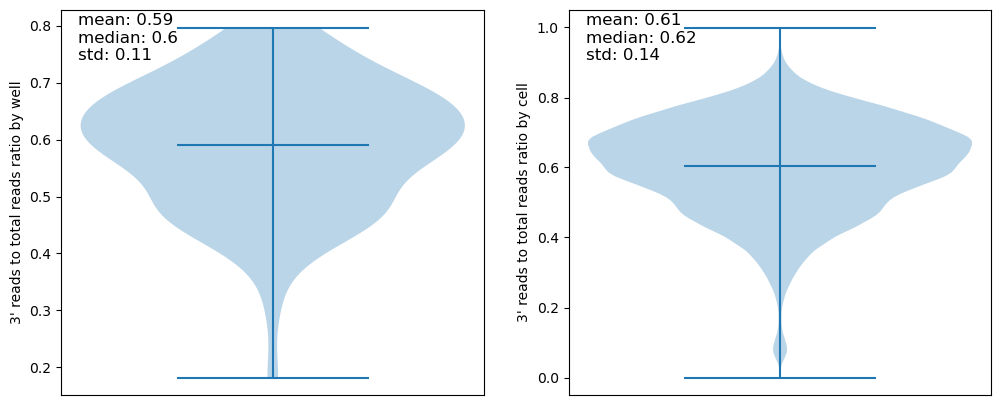

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

violinByWell(ax[0], wells_data.obs)
violinByCell(ax[1], parse_data.obs)

plt.show()

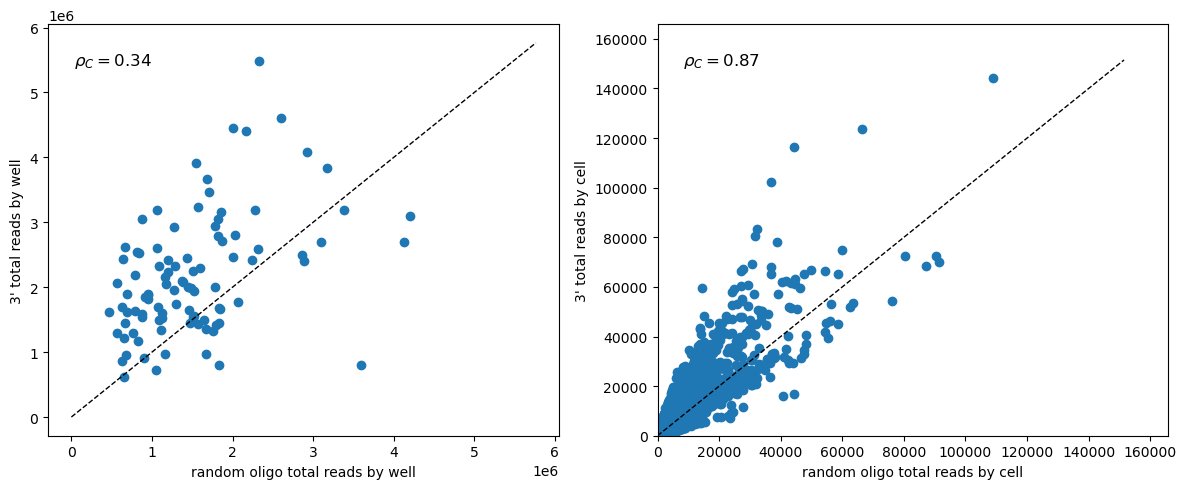

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plotByWell(ax[0], wells_data.obs)
plotByCell(ax[1], parse_data.obs)

plt.tight_layout()
plt.show()

In [13]:
# filter based off of UMI threshold (specified by min_counts)
def refilter(raw_data, min_counts):
    data = raw_data.copy()
    sc.pp.filter_cells(data, min_counts=min_counts)
    data.obs['n_genes'] = data.X.astype(bool).sum(axis=1).A1
    data.var['n_cells'] = data.X.astype(bool).sum(axis=0).A1
    data.obs['n_counts'] = data.X.sum(axis=1).A1
    data.var['percent_counts'] = data.X.sum(axis=0).A1/data.X.sum() * 100
    
    return data

# Knee plot with threshold axes
def knee_plot(ax, raw_data, cutoff = 20):
    knee = np.sort((np.array(raw_data.X.sum(axis=1))).flatten())[::-1]
    cell_set = np.arange(len(knee))
    num_cells = cell_set[knee > cutoff][::-1][0]

    ax.loglog(knee, cell_set, linewidth=5, color="g")
    ax.axvline(x=cutoff, linewidth=3, color="k")
    ax.axhline(y=num_cells, linewidth=3, color="k")
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("")
    ax.set_title(raw_data.uns['title'] + " Knee Plot")

    print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold for {raw_data.uns['title']}")
    data = refilter(raw_data, knee[num_cells])
    
    return data

417,350 cells passed the 150 UMI threshold for Wells


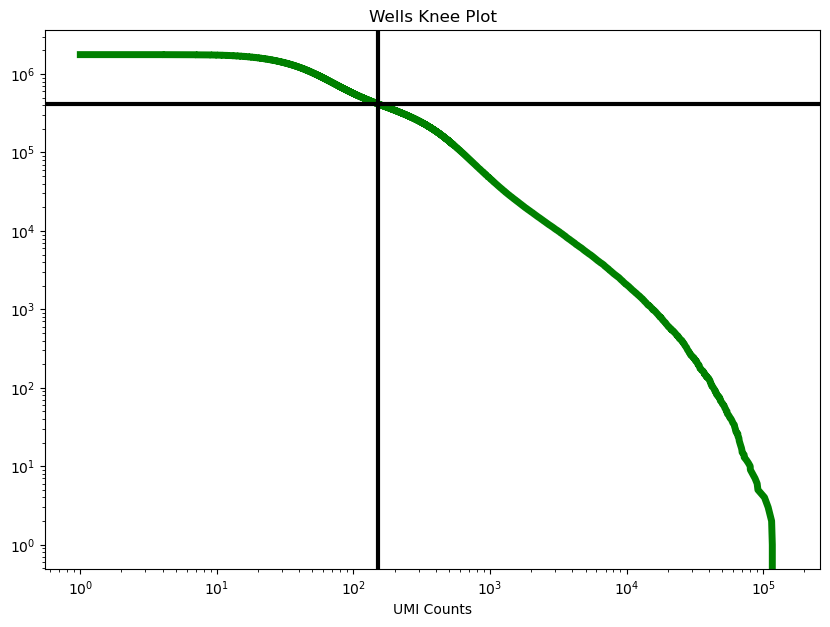

In [14]:
fig, ax = plt.subplots(figsize=(10, 7))

wells_filtered = knee_plot(ax, wells_data, cutoff = 150)
plt.show()

210,113 cells passed the 300 UMI threshold for Parse


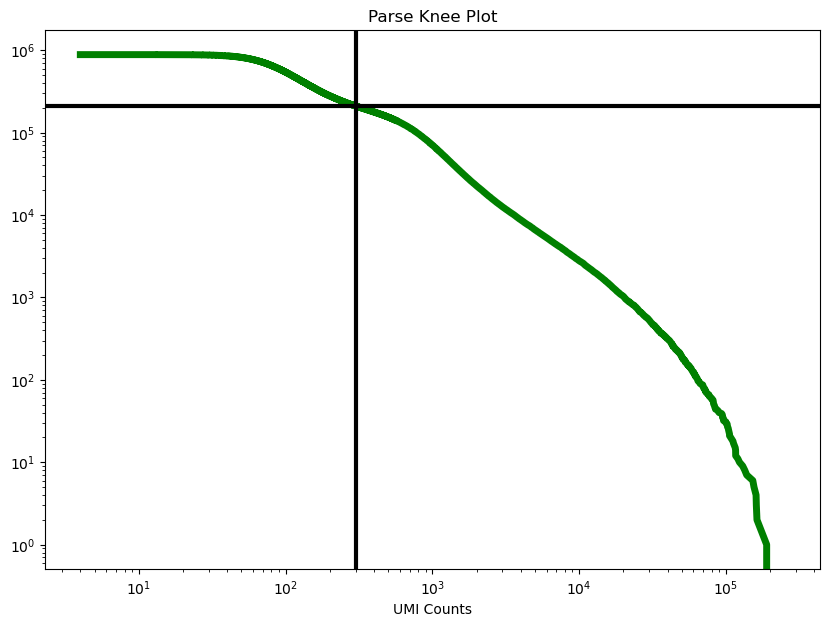

In [15]:
fig, ax = plt.subplots(figsize=(10, 7))

parse_filtered = knee_plot(ax, parse_data, cutoff = 300)
plt.show()

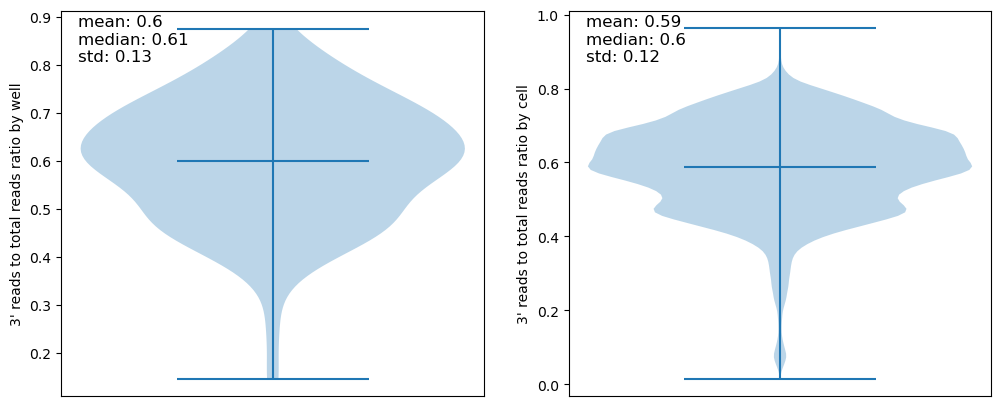

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

violinByWell(ax[0], wells_filtered.obs)
violinByCell(ax[1], parse_filtered.obs)

plt.show()

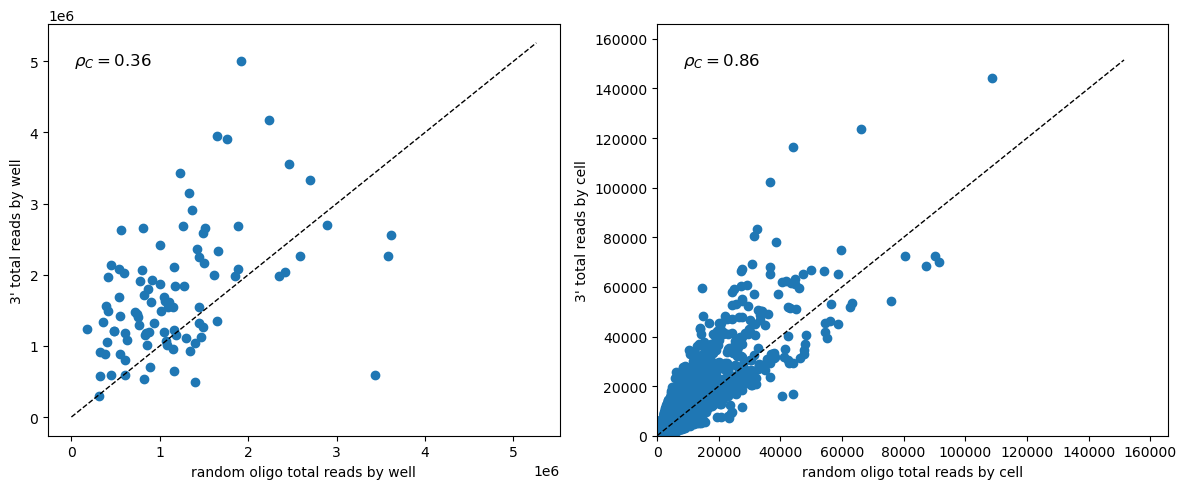

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plotByWell(ax[0], wells_filtered.obs)
plotByCell(ax[1], parse_filtered.obs)

plt.tight_layout()
plt.show()